# Sparkify Project Capstone


In [1]:
# import libraries
import re
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt

import time
import datetime

import pyspark
from pyspark.sql import Row
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Data Scientist Capstone - Sparkify") \
    .getOrCreate()

In [3]:
# Get the current active SparkContext and its configuration settings
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '35ebb8d50da3'),
 ('spark.app.id', 'local-1630485608841'),
 ('spark.driver.port', '37547'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Data Scientist Capstone - Sparkify'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
# Setting seaborn style
sns.set_style("whitegrid")

# <a class="anchor" id="Data-Loading-and-Cleaning">Data Loading and Cleaning</a>

## Data Loading

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Loading data into dataframe
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
# Let's take a quick look at the first row
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [7]:
# Printing schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



The datatypes look fine here.

We will first be looking at the two IDs in the dataset: userId and sessionId

In [8]:
# Quick summary of the descriptives for userId
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [9]:
# Quick summary of the descriptives for sessionId
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



As we can see, there is a total of 286500 rows in the dataset. We will keep that in mind as a reference after cleaning the data later.

In [10]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [11]:
# Check the number of NaNs for userId and sessionId
print('Number of NaNs for userId: ',df.filter(isnull(df['userId'])).count())
print('Number of NaNs for sessionId: ',df.filter(isnull(df['sessionId'])).count())

Number of NaNs for userId:  0
Number of NaNs for sessionId:  0


It seems like NaN values are not an issue here. Let's check further.

In [12]:
# Looking at distinct userIds
df.select('userId').distinct().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
# Check to number of "" values
empty_count = df.filter(df["userId"] == "")
empty_count.count()

8346

The above depiction shows us the distinct userIds. The first position seems to be empty. We will address this in the data cleaning.

In [14]:
# Looking at distinct sessionIds
df.select('sessionId').distinct().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



This issue is not present for the sessionId.

## Data Cleaning

We will address the issue with the empty values in the userIds here and correct the datatype for the sessionId.<br>Also, we will convert the pyspark dataframe to a pandas dataframe for clearer visualizations. 

In [15]:
# Let's address the issue with the 
cleaned_df = df.filter(df['userId']!='')

In [16]:
cleaned_df.select('userId').distinct().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [17]:
# Check the row count after dropping rows
cleaned_df.count()

278154

In [18]:
# The Result should be 0 if everything worked correctly
Test = df.count() - cleaned_df.count() - empty_count.count()
Test

0

In [19]:
# Creating a pandas dataframe from the pyspark dataframe
df_pd = cleaned_df.toPandas()

In [20]:
# Check shape
df_pd.shape

(278154, 18)

In [21]:
# Taking a look at the df
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# <a class="anchor" id="Exploratory-Data-Analysis">Exploratory Data Analysis</a>

## Definition of Churn

Creating a column `Churn` as the label for the model. The `Cancellation Confirmation` events are used to define churn, which happen for both paid and free users.


## Explore Data
EDA is used to compare user behavior for users that stayed and those who churned. Starting by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Step 1: Identify Churned Users and Classify w/ `1` for 'churned' and `0` for 'not churned' 

In [22]:
# Creating a list of the unique pages
pd.unique(df_pd['page'])

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

Looking at the list, the `Cancellation Confirmation` page seems to make most sense as a churn identifier.

In [23]:
# Number of users who churned
page_filter = df_pd[df_pd['page'] == 'Cancellation Confirmation']
page_filter['userId'].count()

52

In [24]:
# Let's check if there are duplicate userIds in case a user has churned and subscribed and churned again
page_filter[page_filter.duplicated('userId')].count()

artist           0
auth             0
firstName        0
gender           0
itemInSession    0
lastName         0
length           0
level            0
location         0
method           0
page             0
registration     0
sessionId        0
song             0
status           0
ts               0
userAgent        0
userId           0
dtype: int64

In [25]:
# These are the IDs of the users who cancelled their subscription
page_filter.filter(items=['userId', 'page']).head(10)

,userId,page
19592,18,Cancellation Confirmation
23072,32,Cancellation Confirmation
36649,125,Cancellation Confirmation
39109,105,Cancellation Confirmation
40728,17,Cancellation Confirmation
43251,143,Cancellation Confirmation
51134,101,Cancellation Confirmation
51579,129,Cancellation Confirmation
52831,121,Cancellation Confirmation
52967,51,Cancellation Confirmation


In the above checks we have identified 52 users that have opened the `Cancellation Confirmation` page. Following our churn definition, these are the users that churned.

We will now add a column `churn` which will contain a `1` if the user churned and a `0` if not.

In [26]:
# Converting back to pyspark dataframe w/ cleaned data for transformations done with PySpark
spark_df=spark.createDataFrame(df_pd)

In [27]:
# Inserting '1' for users that churned and and 0 if not
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [28]:
# creating churn column
spark_df = spark_df.withColumn('churn', churn_event('page'))

In [29]:
# Check 1: Quick look at the columns with '1' in the churn column match the users filtered above
spark_df.select(["userId", "churn"]).where(spark_df.churn == 1).show()

+------+-----+
|userId|churn|
+------+-----+
|    18|    1|
|    32|    1|
|   125|    1|
|   105|    1|
|    17|    1|
|   143|    1|
|   101|    1|
|   129|    1|
|   121|    1|
|    51|    1|
|    87|    1|
|   122|    1|
|    12|    1|
|    58|    1|
|    73|    1|
|     3|    1|
|   106|    1|
|   103|    1|
|    28|    1|
|    54|    1|
+------+-----+
only showing top 20 rows



In [30]:
# Check 2: Quick check if the column w/ churn '0' has been filled correctly
spark_df.select(["userId", "churn"]).where(spark_df.churn == 0).show()

+------+-----+
|userId|churn|
+------+-----+
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|    30|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    74|    0|
|    30|    0|
|     9|    0|
+------+-----+
only showing top 20 rows



The checks above show that the `churn` column has been added successfully.<br>Now we can sort our records for a userId in reverse time order and add up the values in the churn column.

In [31]:
# Sorting by user in reverse time order so churn values can be summed up in 'churn' column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [32]:
# Add the 'churn' column with sum of 1s over records
spark_df = spark_df.withColumn("churn", Fsum("churn").over(windowval))

### Step 2: Compare 'churned' (`1`) w/ 'not churned' (`0`) Users

In the next step we will be comparing the users that churned as well as those who stayed with regards to several characteristics. Firstly, we will take a look at the distribution of the two in the dataset.

In [33]:
# Counting users that churned '1' vs the users that stayed '0'
churn_df = spark_df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()
churn_df.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [34]:
# Using pandas dataframe for visualizations
churn_df_pd = churn_df.toPandas()

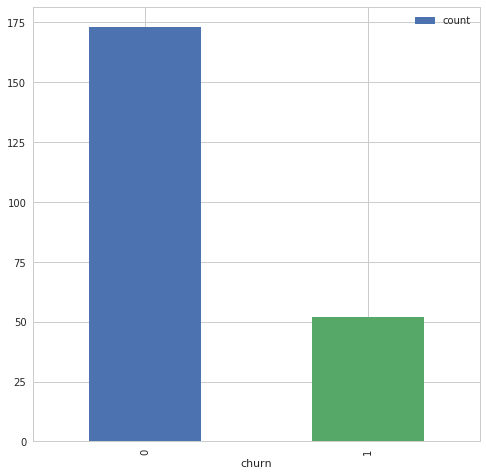

In [35]:
# Quick bar chart to compare 
churn_df_pd.plot.bar(x='churn', y='count', figsize=(8, 8))

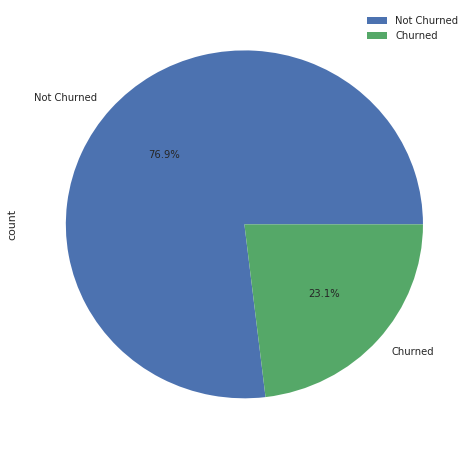

In [36]:
# A pie chart fits this kind of data a bit better
churn_df_pd.plot.pie(y='count', figsize=(8, 8), labels = ('Not Churned', 'Churned'), autopct='%1.1f%%')

**Insights:**
As we can see from the above graphs, there is quite an imbalance here.
> 23 % churned<br>

> 77 % did not churn

### Step 3: Compare the `length` Variable for Churned vs. Stayed

Let's first extract the length for the users that churned:

In [37]:
# Filter for chruned customers
lenght_df = spark_df.filter(spark_df.churn ==1)

In [38]:
# Convert to pandas dataframe for viz
df_pd = lenght_df.toPandas()

In [39]:
# Drop the NaN values (inplace true, so operation inplace and return None)
df_pd.length.dropna(inplace=True)

Now we can extract the length for the users who stayed and compare the distributions:

In [40]:
# Filter for customers that stayed
lenght_df_stay = spark_df.filter(spark_df.churn ==0)

In [41]:
# Convert to pandas dataframe for viz
df_pd_stay = lenght_df_stay.toPandas()

In [42]:
# Drop the NaN values (inplace true, so operation inplace and return None)
df_pd_stay.length.dropna(inplace=True)

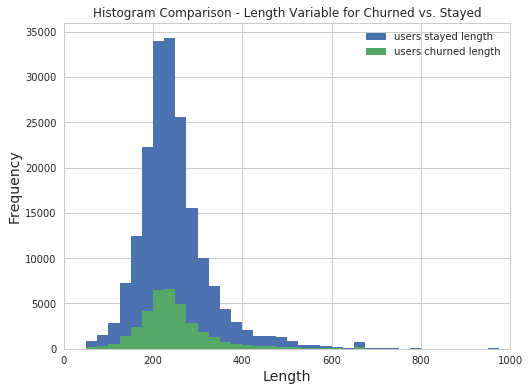

In [43]:
# Histogram
bin_edges = np.arange (50, df_pd_stay['length'].max()+25, 25)
plt.figure(figsize=(8,6))
plt.hist(data = df_pd_stay, x = 'length', bins = bin_edges, label="users stayed length")
plt.hist(data = df_pd, x = 'length', bins = bin_edges, label="users churned length")
plt.xlim(0,1000)
plt.xlabel('Length', size=14)
plt.ylabel('Frequency', size=14);
plt.title("Histogram Comparison - Length Variable for Churned vs. Stayed")
plt.legend(loc='upper right');

**Insights:**<br>As we can see in the overlay of the histograms, the distributions are quite similar. This will most likely not be a good predictor for our churn rate. Let's take a look at another feature.

### Step 4: Compare `gender` for Churned vs. Stayed

In [44]:
# Create dataframe for gender grouped by churn and gender
gender_df = spark_df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [45]:
# Show gender df 
gender_df.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [46]:
# Convert to pandas dataframe for viz
gender_df = gender_df.toPandas()

In [47]:
# Sorting
gender_df = gender_df.sort_values('count', ascending = False)

In [48]:
# male churn rate
print('Gender \'male\' churn in %:')
male_churn = 32/(89+32)
male_churn

Gender 'male' churn in %:


0.2644628099173554

In [49]:
# female churn rate
print('Gender \'female\' churn in %:')
fem_churn = 20/(20+84)
fem_churn

Gender 'female' churn in %:


0.19230769230769232

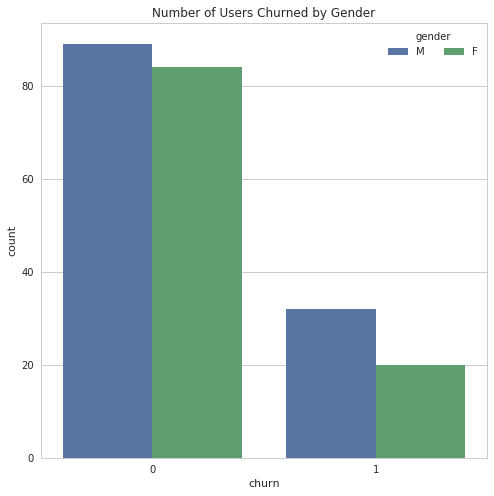

In [50]:
# Creating bar chart
plt.figure(figsize = [8,8])
ax = sns.barplot(data = gender_df, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users Churned by Gender");

**Insights:**<br>The above data indicates a higher tendency towards churning for male users.

### Step 5: Compare `level` for Churned vs. Stayed<br>
`Level` refers to the two subscription models, where users w/ `paid` subscriptions do not see advertising while `free` subscription users do. Knowing that one might assume that free users are more likely to churn due to advertising. Let's see if we can verify that assumption.

In [51]:
# Creating the level df
level_df = spark_df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [52]:
# Quick glance at the data
level_df.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [53]:
# Churn rate for users w/ free subscription
print('Level \'free\' churn in %:')
free_churn = 46/(46+149)
free_churn

Level 'free' churn in %:


0.2358974358974359

In [54]:
# Churn rate for users w/ paid subscription
print('Level \'paid\' churn in %:')
paid_churn = 36/(129+36)
paid_churn

Level 'paid' churn in %:


0.21818181818181817

In [55]:
# Convert to pandas dataframe for viz
level_df = level_df.toPandas()

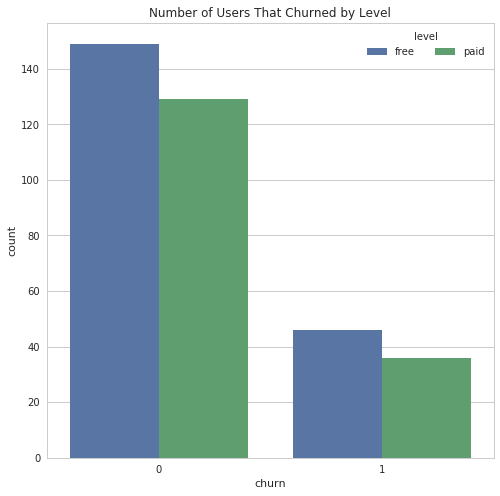

In [56]:
# plot the barplot using seaborn
plt.figure(figsize = [8,8])
ax = sns.barplot(data = level_df, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned by Level");

**Insights:**<br>More users w/ a `free` (~24%) subscription level have churned when compared to the `paid` (~22%) users. The difference is rather marginal, so it is difficult to say if our previous assumption was really right.

### Step 6: `Page` Visited by Users that Churned vs. Users That Stayed
Next we can examine if there were different pages visited by users that churned compared to those that remained.

In [57]:
# Creating the dataframe for 'page'
page_df = spark_df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [58]:
page_df.show()

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [59]:
# Convert to pandas dataframe for viz
page_df = page_df.toPandas()

In [60]:
# Create counts
churn_count =  page_df[page_df['churn'] == 1].sum() 
stay_count =  page_df[page_df['churn'] == 0].sum()

Calculate the churn rate and create as a column on df.

In [61]:
# Calculating rate of pages visited by churned users and those who stayed
page_df['rate'] = np.where(
    page_df['churn'] == 0, page_df['count']/stay_count['count'], np.where(
    page_df['churn'] == 1, page_df['count']/churn_count['count'],page_df['count']/churn_count['count']))

In [62]:
page_df.head(40)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


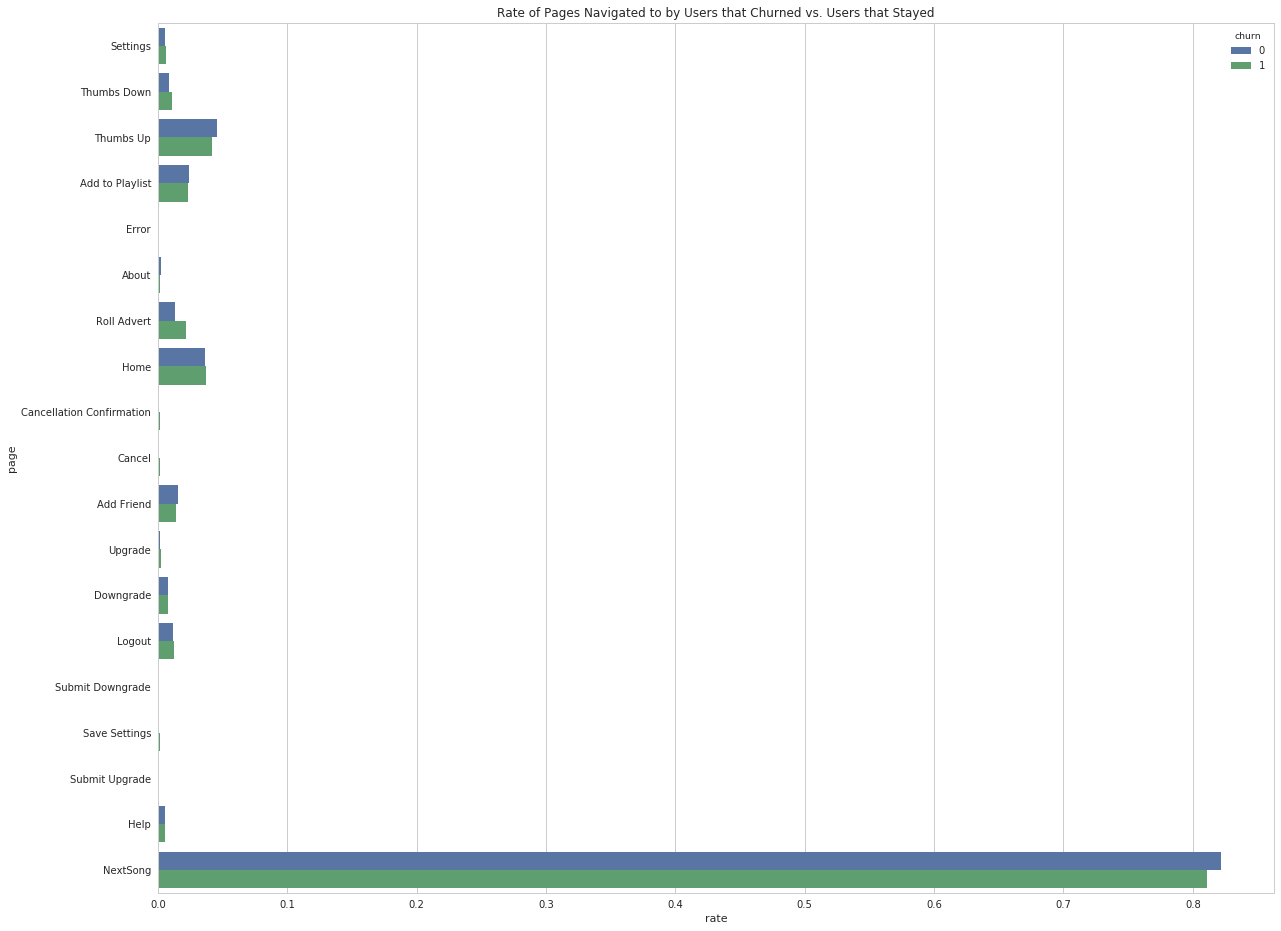

In [63]:
# Visualize results
plt.figure(figsize=[20,16])
sns.barplot(data = page_df, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');

**Insights:**<br>
The most popular action for both user groups was the `NextSong` action.  
Churned users used the `thumbs down` action more while the `thumbs up` action was clicked more often by the loyal users. Those who were more likely to stay also added friends and songs to playlists.

### Step 7: Calculation of Songs per Hour
We will now calculate the number of songs listened to by churn and non churn users per hour.

In [64]:
# Getting hour from timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [65]:
# Create an hour column
spark_df = spark_df.withColumn("hour", get_hour(spark_df.ts))

In [66]:
spark_df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=nan, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18')

We can first focus on those who did not churn.

In [67]:
# Creation of df with those who did not churn and which counts at what time user goes to next song page
songs_per_hour_stay = spark_df.filter((spark_df.page == "NextSong") & (spark_df.churn == 0)).groupby(spark_df.hour).count().orderBy(spark_df.hour.cast("float"))

In [68]:
songs_per_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
|  20| 9107|
|  21| 8853|
|  22| 8526|
|  23| 8085|
+----+-----+



In [69]:
# Convert to pandas and then to numeric
songs_per_hour_stay_pd = songs_per_hour_stay.toPandas()
songs_per_hour_stay_pd.hour = pd.to_numeric(songs_per_hour_stay_pd.hour)

In [70]:
# Show results
songs_per_hour_stay_pd

,hour,count
0,0,7527
1,1,7035
2,2,7014
3,3,7063
4,4,6914
5,5,6960
6,6,6836
7,7,6873
8,8,7023
9,9,7268


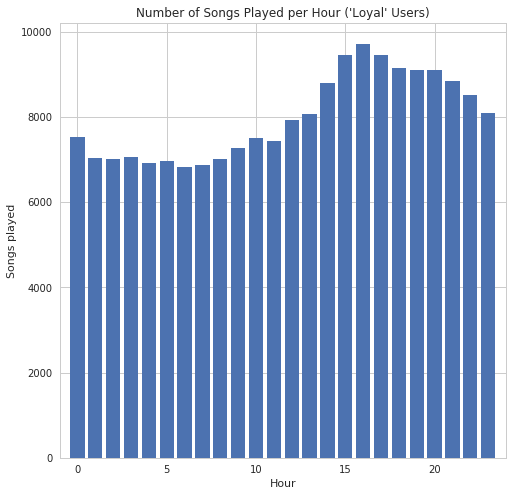

In [71]:
# Visualize data points
plt.figure(figsize = [8,8])
plt.bar(songs_per_hour_stay_pd["hour"], songs_per_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour ('Loyal' Users)");

**Insights:**<br>
There is a peak at 3pm and a higher higher plateau between 6pm and 8pm. Will will look at churned users with the same process.

In [72]:
# Create df w/ churned users
songs_per_hour_churned = spark_df.filter((spark_df.page == "NextSong") & (spark_df.churn == 1)).groupby(spark_df.hour).count().orderBy(spark_df.hour.cast("float"))

In [73]:
songs_per_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows



In [74]:
# convert to pandas and to numeric
songs_per_hour_churned = songs_per_hour_churned.toPandas()
songs_per_hour_churned.hour = pd.to_numeric(songs_per_hour_churned.hour)

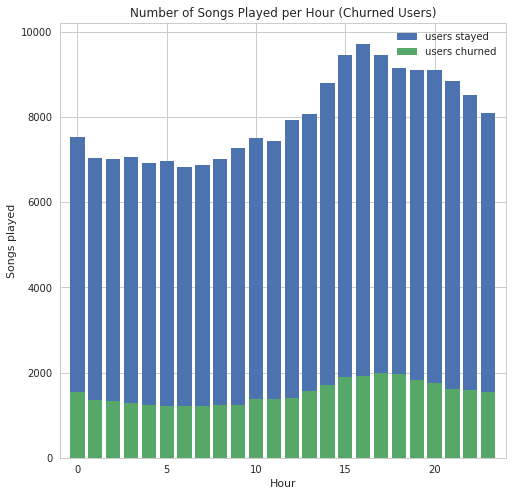

In [75]:
#plot distribution of songs per hour for churned
plt.figure(figsize = [8,8])
plt.bar(songs_per_hour_stay_pd["hour"], songs_per_hour_stay_pd["count"], label="users stayed")
plt.bar(songs_per_hour_churned["hour"], songs_per_hour_churned["count"], label="users churned")
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.legend(loc='upper right');
plt.title("Number of Songs Played per Hour (Churned Users)");

**Insights**<br>
Putting the distributions over another we can see that it is fairly similar for both groups. However, it is very apparent that churned users have listened to less ongs overall.

### Step 8: Calculating Songs Per Session for Churned vs. Loyal
We can compare the groups by looking at the average values:

In [76]:
# First, let's get the count by the 'next song' 
songs_df = spark_df.filter(spark_df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [77]:
# Now let's look at the average for churn
songs_df.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [78]:
songs_df = songs_df.groupby('churn').agg({"count":"avg"})

In [79]:
# convert this to pandas df
songs_df = songs_df.toPandas()

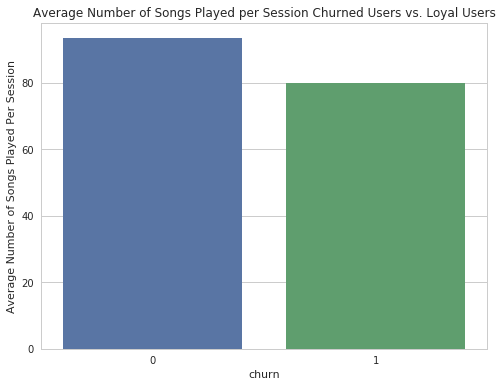

In [80]:
#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = songs_df, x = 'churn', y='avg(count)')
plt.title("Average Number of Songs Played per Session Churned Users vs. Loyal Users")
plt.ylabel("Average Number of Songs Played Per Session");


**Insights:**<br>
Per session the churned users were listening to fewer songs than those who stayed.

### Step 9: Number of Unique Artists Listened to
A similar chart for the number of artists that users listened to is created here.

In [81]:
# Let's get the count first
artists_df = spark_df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [82]:
# get averages
artists_df.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [83]:
# convert to pandas
artists_df = artists_df.toPandas()

Text(0.5,1,'Number of Artists Listened to on Sparkify')

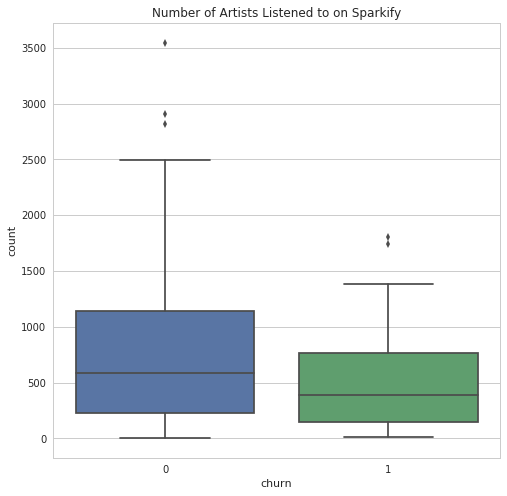

In [84]:
# Visualizing Boxplot to see the max and medians for both groups
plt.figure(figsize = [8,8])
ax = sns.boxplot(data = artists_df, x = 'churn', y='count')
plt.title("Number of Artists Listened to on Sparkify")

**Insights:**<br>
The loyal users listened to a greater variety of artists compared to the churned users.

### Step 10: Location
Let's see if the location had any influence on churn.

In [85]:
# Count by location
spark_df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



The data is a bit too granular, let's focus on the US state rather than the city. We can take the last two letters to get the state information.

In [86]:
# Extract last two characters
get_state = udf(lambda x: x[-2:])

In [87]:
# Creating the state column
state_df = spark_df.withColumn("state", get_state(spark_df.location))

In [88]:
# Quick check
state_df.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=nan, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18', state='CT'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18', state

In [89]:
# Drop duplicates
state_df = state_df.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [90]:
# convert to pandas 
state_df = state_df.toPandas()

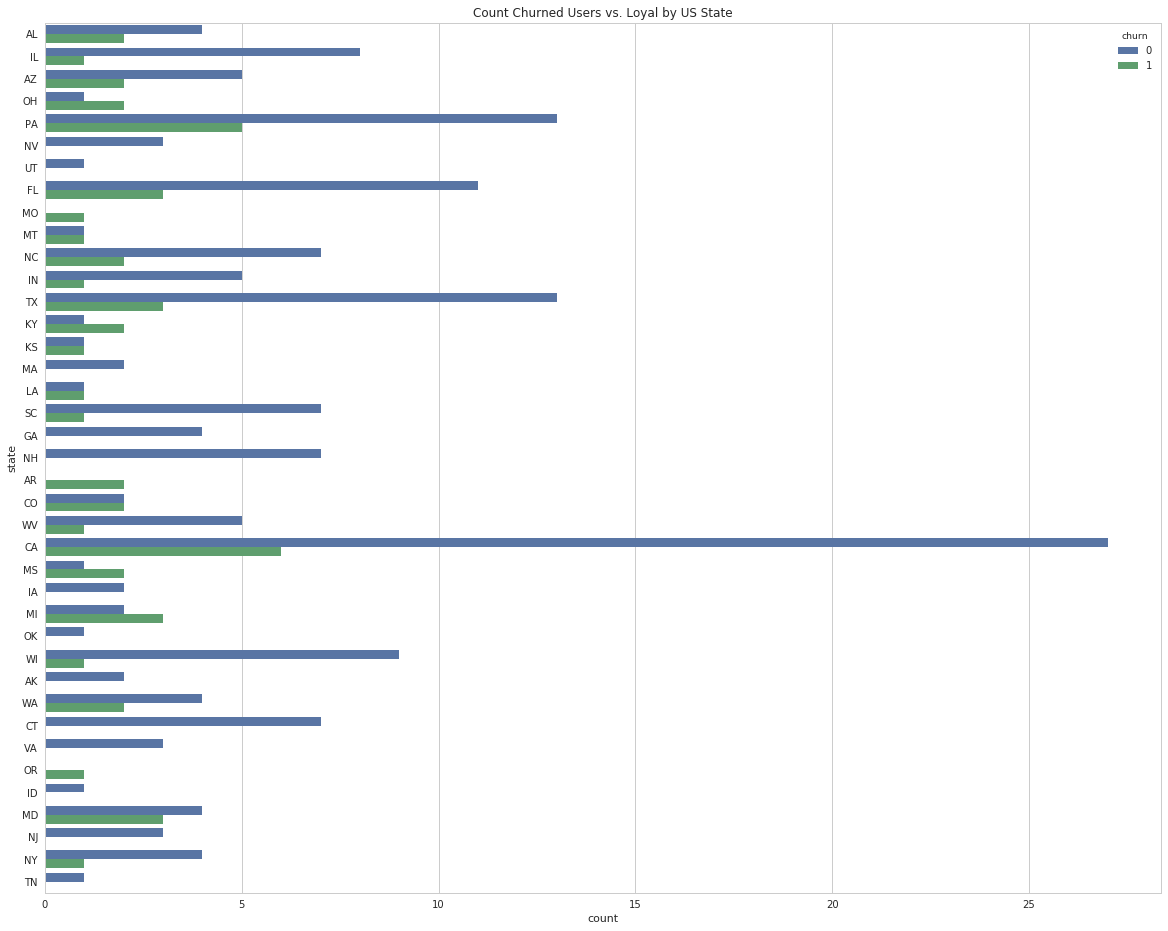

In [91]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = state_df, x = 'count', y = 'state', hue = 'churn')
plt.title('Count Churned Users vs. Loyal by US State');

**Insights:**<br>
`CA` had the most users. In `MI`, `KI` and `OH` more users churned than there were users that stayed.
Engineering a useful feature for this might be difficult. We will focus on another column for now - `operating systems and browsers`.

### Step 11: UserAgent: Operating System and Browsers
We will now extract the OS to see the effect on churn.

In [92]:
opsys_df = spark_df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])

In [93]:
opsys_df.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|100010|"Mozilla/5.0 (iPh...|    0|
|200002|"Mozilla/5.0 (iPh...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
|   124|"Mozilla/5.0 (Mac...|    0|
|    51|"Mozilla/5.0 (Win...|    1|
|     7|Mozilla/5.0 (Wind...|    0|
|    15|"Mozilla/5.0 (Win...|    0|
|    54|Mozilla/5.0 (Wind...|    1|
|   155|"Mozilla/5.0 (Win...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|   132|"Mozilla/5.0 (Mac...|    0|
|   154|"Mozilla/5.0 (Win...|    0|
|   101|Mozilla/5.0 (Wind...|    1|
|    11|Mozilla/5.0 (Wind...|    0|
|   138|"Mozilla/5.0 (iPa...|    0|
|300017|"Mozilla/5.0 (Mac...|    0|
|100021|"Mozilla/5.0 (Mac...|    1|
|    29|"Mozilla/5.0 (Mac...|    1|
|    69|"Mozilla/5.0 (Win...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [94]:
# Converting to pandas
opsys_df = opsys_df.toPandas()

In [95]:
# Getting the possible list of operating systems
opsys_df.userAgent.value_counts().head()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"               24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                      18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"    16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"    12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"       12
Name: userAgent, dtype: int64

In [96]:
# Creating a list of OS
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

In [97]:
# Creating 'OS' column and extract strings that match our os_list and add to column 
opsys_df['os'] = opsys_df.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [98]:
# Quick check
opsys_df.head()

,userId,userAgent,churn,os
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows


In [99]:
# Count by OS
opsys_df.os.value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: os, dtype: int64

In [100]:
# Defining order for the plot
OS_order = opsys_df.os.value_counts().index

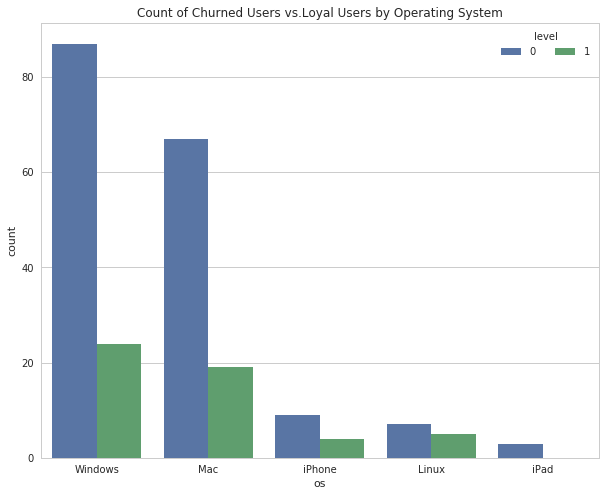

In [101]:
# Comparing users by OS
plt.figure(figsize=[10,8])
sns.countplot(data = opsys_df, x = 'os', hue ='churn', order = OS_order)
plt.title('Count of Churned Users vs.Loyal Users by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

**Insights:**<br>
Users were mostls using `Windows`. `Linux` users showed the highest churn rate. Since the number isso low, though, it won't be used in the model.

Similarly, we can check if browsers affect churn rates using the same process.

In [102]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [103]:
opsys_df['browser'] = opsys_df.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [104]:
opsys_df.browser.value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

In [105]:
# Defining order for plot
browser_order = opsys_df.browser.value_counts().index

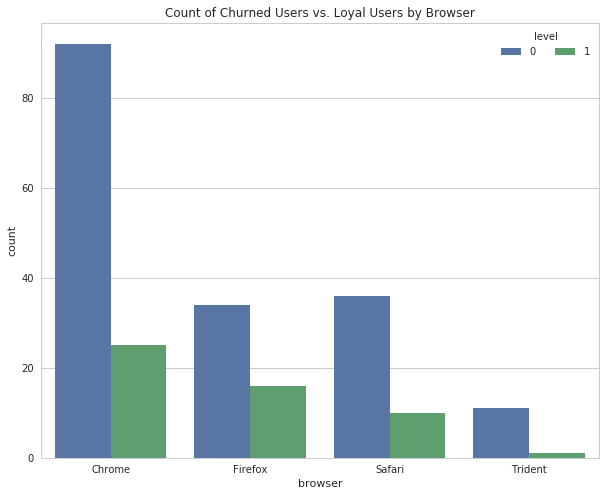

In [106]:
plt.figure(figsize=[10,8])
sns.countplot(data = opsys_df, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Churned Users vs. Loyal Users by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

**Insights:**<br>
`Chrome` is clearly the most popular browser. Relatively, `Firefox` users are the most likely to churn. The fewest users used `Trident`. It seems like there is no real link between browser choice and churn rate.

### Step 11: Days Since Registration for Sparkify
Finally, let's take a look at the number of days since a user had registered.

In [107]:
days_df = spark_df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [108]:
# Ordering by latest timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [109]:
# Creating a rank with the most recent timestamp as rank on top
days_df = days_df.withColumn("Rank", dense_rank().over(w))

In [110]:
days_df.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [111]:
# Getting those with a rank of 1
days_df = days_df.filter(days_df.Rank == 1).drop(days_df.Rank)

In [112]:
days_df.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [113]:
# Need to minus the registration from ts 
days_df = days_df.withColumn("delta_days", (days_df['ts']) - (days_df['registration']))

In [114]:
days_df.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [115]:
days_df = days_df.withColumn('days',(days_df['delta_days']/1000/3600/24))

In [116]:
days_df.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [117]:
# pandas for viz
days_df_pd = days_df.toPandas()

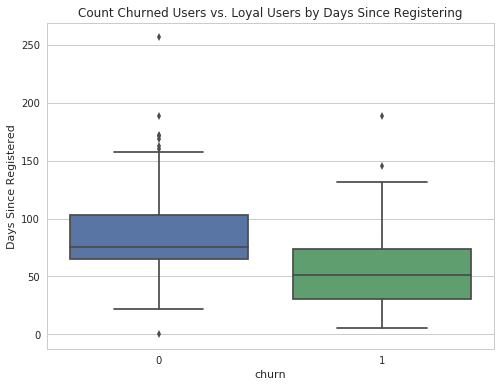

In [118]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = days_df_pd, x = 'churn', y ='days')
plt.title('Count Churned Users vs. Loyal Users by Days Since Registering')
plt.ylabel("Days Since Registered");

**Insights:**<br>
User who had been registered for longer are on average more loyal. More recently registered users are more likely to churn.

# <a class="anchor" id="Feature-Engineering">Feature Engineering</a>

Now that we have gathered the first insights with EDA, we can start building out the most promising features to train our model on.

We will be focusing on:

**Categorical:**<br>
`gender`<br>
`level`

**Numerical:**

`number of songs per session`<br>
`number of rollads actions`<br>
`number of thumb down actions`<br>
`number of thumbs up actions`<br>
`number of friends added`<br>
`number of songs added to playlist`<br>
`number of different artists listened to on Sparkify`<br>
`number of days since registering`<br>

Furthermore, we will add a label for `churn` to be able to join these together in the end.
A dataFrame where each row represents the information pertaining to each individual user will thus be created.
When the userId is dropped, the df can be vectorized, standardized and delivered to various ML algorithms.
learning algorithms.

We will start by converting our categorical variable `gender` and `level` to numeric variables.

### Gender

The first feature will be `gender` which is categorical.
1 is assigned for 'female' and a 0 for 'male'.

In [119]:
gender_f1 = spark_df.select(['userId', 'gender']).dropDuplicates()

In [120]:
# Creating a gender column 
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [121]:
gender_f1.count()

225

In [122]:
# Quick check
gender_f1.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Level

Now, we will focus on the categorical variable `level`.
Since, the level can be subject to change, we need to take the most recent only. We can use the rank procedure from before.

In [123]:
df2 = spark_df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [124]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [125]:
df2 = df2.withColumn("Rank", dense_rank().over(w))

In [126]:
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [127]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)

In [128]:
level_f2 = level_f2.drop('ts')

In [129]:
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [130]:
level_f2.count()

225

In [131]:
level_f2.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average Number of songs per session
The third feature will be average number of songs per session for each user.

In [132]:
song_f3 = spark_df.filter(spark_df.page == "NextSong").groupBy('userId','sessionId').count()

In [133]:
spark_df.filter(spark_df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [134]:
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})

In [135]:
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

In [136]:
song_f3.count()

225

In [137]:
song_f3.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



### Number of rollads actions
With the next feature we are considering the number of `roll advert` actions.
This had a higher number of roll ad count for churned users since those who use the app for free see ads while paid users are not shown ads.

In [138]:
rollad_f4 = spark_df.select(["userId", "page"])

In [139]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [140]:
# Creating rollad column
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))

In [141]:
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")


In [142]:
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

In [143]:
rollad_f4.count()

225

In [144]:
rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
+------+-------+
only showing top 2 rows



### Number of thumb down actions
The fifth feature we can add to our feature dataframe is thumbs down. Users who had churned in the past had performed more thumbs down actions than those who stayed with the service.

In [145]:
thumbdown_f5 = spark_df.select(["userId", "page"])

In [146]:
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [147]:
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))

In [148]:
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")

In [149]:
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [150]:
thumbdown_f5.count()

225

In [151]:
thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



### Number of thumbs up actions
We can do the same for thumb up actions. Users who stayed with the service had performed more thumbs up actions in the past.

In [152]:
thumbup_f6 = spark_df.select(["userId", "page"])

In [153]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [154]:
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))

In [155]:
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")

In [156]:
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [157]:
thumbup_f6.count()

225

In [158]:
thumbup_f6.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
+------+---------+
only showing top 2 rows



### Number of friends added
Similarly, number of friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [159]:
friend_f7 = spark_df.select(["userId", "page"])

In [160]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [161]:
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))

In [162]:
friend_f7 = friend_f7.groupby('userId').sum("add_friend")

In [163]:
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

In [164]:
friend_f7.count()

225

In [165]:
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
+------+----------+
only showing top 2 rows



### Number of songs added to playlist
Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [166]:
playlist_f8 = spark_df.select(["userId", "page"])

In [167]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [168]:
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))

In [169]:
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")

In [170]:
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

In [171]:
playlist_f8.count()

225

In [172]:
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
+------+--------+
only showing top 2 rows



### Number of different Artists Listened to on Sparkify

As we discovered in EDA, users that listened to more diverse artists were less likely to churn.

In [173]:
artists_f9 = spark_df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [174]:
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

In [175]:
artists_f9.count()

225

In [176]:
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



### Number of Days Since Registering
Number of days since registering also looked useful from our EDA. We saw that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.



In [177]:
days_df.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [178]:
days_f10 = days_df.drop('registration', 'ts', 'churn', 'delta_days')

In [179]:
days_f10.count()

225

In [180]:
days_f10.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label
Now we can create our label column indicating if the user churned (1) or not (0).

In [181]:
label = spark_df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [182]:
label = label.drop('count')

In [183]:
label.count()

225

In [184]:
label = label.withColumnRenamed("churn", "label")

In [185]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



### Create Features Dataset
Now that we have our features we need to join these together on userId.

In [186]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

In [187]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19

Now we can drop the userId.

In [188]:
feature_df = feature_df.drop('userId')

In [189]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19.455844907407407|    1|
|     0|    0|21.428571428571427

Now we have a dataframe with all the features we can into our model where each row represents a user.However first we need to do some preprocessing.

# <a class="anchor" id="Preprocessing">Preprocessing</a>

In [190]:
# Printing schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



Now we need to take these columns and convert into the numerical datatypes that will be used in our model: integers and floats. We can use write a function to adhere to DRY principles.

In [191]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [192]:
# Check
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



The next stage of preprocessing is to vectorise our features.

### Vector Assembler
The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [193]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")

In [194]:
feature_df = assembler.transform(feature_df)

In [195]:
feature_df.show()

+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|      days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|      74.0|   118.0|     2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0|      28.0|    52.0|     1386.0| 19.455845|  1.0|[0.0,1.0,211.1000...|


### Standardization
Now that we have our vectors we can standardise our values. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [196]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [197]:
scaler_model = scaler.fit(feature_df)

In [198]:
feature_df = scaler_model.transform(feature_df)

In [199]:
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 2.413, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_down=6.0, thumbs_up=21.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]))]

We can see from above that standardization has worked by comparing vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), to features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]).

### Train / Test / Validation Split
Let's check how many records we have in total is 225 as it should be.

In [200]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This count is what we would expect, now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. I've included the same seed for the different machine learning models so that my results can be reproduced.

In [201]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:142
Test Dataset:47
Validation Dataset:36


# <a class="anchor" id="Modeling">Modeling</a>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Now we have created our features dataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:

Logistic Regression
Random Forest Classifier
Gradient-Boosted Tree Classifier
Linear Support Vector Machine
Naive Bayes
We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time.

Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.

Now we can start modelling. When we identify the model with the best F1 score, accuracy and time we will then tune the model.

The models I have selected are below with the reasons why these have been chosen. Each model that has been chosen is suitable for our binary classification problem of predicting churn.

Logistic Regression: Logistic regression is the first machine learning algorithm we can try. Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability. Logistic regression is also easy to implement, interpret and is efficient to train. It is also less inclined to overfitting.
Random Forest: Random Forest is a powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. RF is also robust and has good performance on imbalanced datasets like we have here.
Gradient Boosted Tree Classifier: GBT provides good predictive accuracy. This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. There is a risk of overfitting with GBT so this needs to be considered. However GBT performs well with unbalanced data which we have here.
Linear SVC: SVC is another supervised learning binary classification algorithm. It works well with clear margins of separations between classes and is memory efficient.
Naive Bayes: Finally, we will try Naive Bayes. This is another classifier algorithm that is easy to implement and is fast.
Training the Models & Evaluating the Model Performance
Steps:

Instantiate
Fit Models on Train
Predicting
Evaluating


In [202]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1996)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1996)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [203]:
#list of models
model_list = [lr,rf,gbt,lsvc,nb]

In [204]:
# evaluator we are using is multiclassclassificationevaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [205]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)


LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 133.10692167282104 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6523297491039427
The accuracy of the LogisticRegression model is: 0.7222222222222222
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 209.52844858169556 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.874074074074074
The accuracy of the RandomForestClassifier model is: 0.8888888888888888
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 232.2926766872406 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.8888888888888888
The accuracy of the GBTClassifier model is: 0.8888888888888888
LinearSVC training started
Line

Now that we have our results we can choose our best model. Random Forest and Gradient Boosted Trees performed well but random forest was faster so I will choose this one to tune.



### Model Tuning for Best Models:
Now we can tune our model using paramGridbuilder and CrossValidator. I am going to select Random Forest since this is the best compromise for F1 score, accuracy, and time to run. Random Forrest had a F1 score of 0.87 and accuracy of 0.88 and took 2 min 57s compared to GTB which achieved a similar score of 0.88 for both F1 score and accuracy but took 3 min 51s.

#### Random Forest


In [206]:
#Let's see what parameters we can tune.
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

#### Parameters
I will select numTrees and maxDepth for our RF model tuning.

- NumTrees: I have chosen to go up to 100 trees to improve performance. Since these trees are individual randomised models in an ensemble there is not a great risk of overfitting with this numTrees parameter.
- Maxdepth: I have chosen a max of 15 to reduce the possibility of overfitting. Anything over 15 would increase the risk of overfitting greatly.
- Numfolds: I originally had numFolds = 5 but had to change to 3 to speed up the process.


In [207]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [208]:
%%time
cvModel = crossval.fit(train)

CPU times: user 10.2 s, sys: 3.65 s, total: 13.8 s
Wall time: 40min 28s


In [209]:
cvModel.avgMetrics

[0.7872461178783523,
 0.781651082029746,
 0.781651082029746,
 0.7398446323786516,
 0.7474330923545608,
 0.7474330923545608,
 0.75244213111646,
 0.753904771551569,
 0.753904771551569]

#### Best Model Performance Results:
We can now get the final results for our random forest model.



In [210]:
results = cvModel.transform(valid)

In [211]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [212]:
best_model = cvModel.bestModel

In [213]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  20
Best Param (MaxDepth):  5


In [214]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.6805555555555557


In [215]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.7777777777777778


Here our RF model achieved a F1 and accuracy of 0.88. Accuracy means the number of correctly predicted data points out of all the predictions. So for an accuracy of 0.88 or 88% we get 88 correct predictions out of 100 total predictions. In our context we can use a confusion matrix to think about this:

Confusion_Matrix2_2.png

Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

F1 here is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.

1_wUdjcIb9J9Bq6f2GvX1jSA.png

Feature Importance:
Finally, we can check the feature importance for our best model and plot this in a chart.



In [216]:
importances = best_model.featureImportances

In [217]:
x_values = list(range(len(importances)))

In [218]:
feature_list = list(["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"])

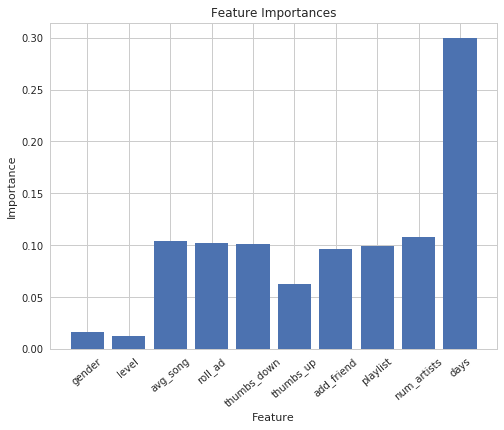

In [219]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

Here we can see that the feature with the highest importance was days since registered. Gender and level were the least important features.



## Conclusions

We started the project with a small dataset of just 128MB and 225 unique customers. After loading and cleaning our data we explored the dataset for useful features to predict churn and were able to build out the most promising features. We then preprocessed these and used the features with different machine learning algorithms. Random Forest performed the best, so we tuned the model and achieved an accuracy and F1 score of 0.88.

Business Impact:
Now, Sparkify can use this information to target customers who are likely to churn and offer attractive incentives to stay, thereby saving Sparkify revenue and getting the customer a nice deal. Since we found that newer customers are more likely to churn, we could target them with a nice free trial of the premium service without those pesky ads! Sparkify could also work on music recommendation system so they can recommend songs that users will enjoy more and thumbs down less.

Project Reflection
From this project I have learned how to manipulate datasets with Spark to engineer relevant features for predicting churn. I used Spark MLib to build machine learning models to predict churn. It was interesting to start with a dataset which had the customers' user interactions and then use this to predict whether or not they were likely to churn. The best model was the Random Forest classifier which achieved an accuracy and F1 score of 0.88. It was interesting to build my first model for predicting churn in pyspark as opposed to pandas.

Future Work
This project could have been improved by:

- Doing more feature engineering to select the best features to get a better score
- Considered overfitting problems in more depth
- Analysing mispredicted users


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.